In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns
import pandas as pd
from scipy.optimize import minimize
from scipy.optimize import curve_fit
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib.lines import Line2D
import os

In [4]:
def psychometric(s, mu, sigma, lapse1, lapse2):
    return lapse1 + (1 - lapse1 - lapse2) * norm.cdf(s, mu, sigma)

def add_previous_n_trials_data(group, n=1):
    """
    Add previous n trial data (stim_relative_binned, choice, and correct) to the DataFrame for each participant.
    
    Parameters
    ----------
    group : pd.DataFrame
        The data for a single participant, assumed to have the columns 'Trial', 'No_response',
        'stim_relative_binned', 'choice', and 'correct'.
    n : int
        Number of previous trials to include.
        
    Returns
    -------
    group : pd.DataFrame
        The modified input DataFrame with additional columns for previous trial data
        ('stim_relative_1', 'choice_1', 'correct_1', ... up to n).
    """
    for i in range(1, n+1):
        # Shift the stim_relative_binned, choice, and correct columns by i rows to get previous trial data
        group[f'stimulus_{i}'] = group['stimulus'].shift(i)
        group[f'choice_{i}'] = group['choice'].shift(i)
        group[f'correct_{i}'] = group['correct'].shift(i)

    return group

def scale_probability(prob, scale=1):
    """
    Adjust a probability using a sigmoid function.
    
    Parameters:
        prob (float): Original probability to adjust.
        scale (float): Scaling factor to apply to the input of the sigmoid function.
                       Values greater than 1 will push probabilities away from the extremes (0 and 1),
                       while values less than 1 will pull them towards 0.5.
                       
    Returns:
        float: Adjusted probability.
    """
    # Convert probability to a value suitable for scaling
    log_odds = np.log(prob / (1 - prob))
    
    # Apply scaling
    scaled_log_odds = log_odds * scale
    
    # Convert back to probability using sigmoid function
    scaled_prob = 1 / (1 + np.exp(-scaled_log_odds))
    
    return scaled_prob

def calculate_new_probability(row, scale= 0.1):
    try:
        if row['correct_1'] == 1:
            if row['probability'] < 0.5 and row['choice_1'] == 0: # probability was low and the choice was 0
                return scale_probability(row['probability'], 1 + scale)
            elif row['probability'] < 0.5 and row['choice_1'] == 1: # probability was low and the choice was 1
                return scale_probability(row['probability'], 1 - scale)
            elif row['probability'] > 0.5 and row['choice_1'] == 0: # probability was high and the choice was 0
                return scale_probability(row['probability'], 1 - scale)
            elif row['probability'] > 0.5 and row['choice_1'] == 1: # probability was high and the choice was 1
                return scale_probability(row['probability'], 1 + scale)
            else:
                return row['probability']
        else:
            return row['probability']
    except:
        return row['probability']

In [5]:
# Break execution at this cell 
raise Exception('Stop here')

Exception: Stop here

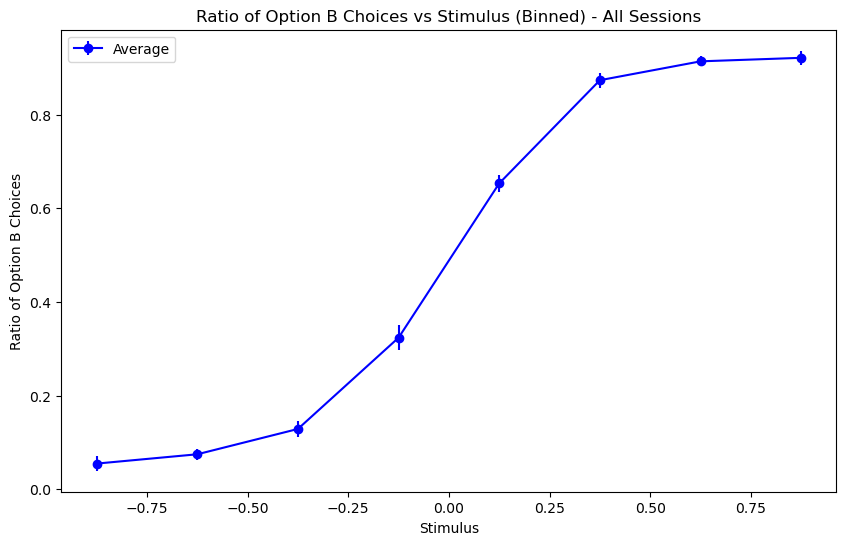

In [ ]:
def simulate_agent_data(num_sessions, num_trials_per_session, lapse1, lapse2, mu, sigma):
    stimuli = np.random.uniform(-1, 1, size=(num_sessions, num_trials_per_session))
    choices = np.zeros_like(stimuli)

    for session in range(num_sessions):
        for trial in range(num_trials_per_session):
            s = stimuli[session, trial]
            psyc = lapse1 + (1 - lapse1 - lapse2) * norm.cdf(s, mu, sigma)
            choice = np.random.choice([0, 1], p=[1 - psyc, psyc])
            choices[session, trial] = choice

    return stimuli, choices

# Parameters
num_sessions = 10
num_trials_per_session = 300
lapse1 = 0.05
lapse2 = 0.05
mu = 0
sigma = 0.3

# Simulate data
stimuli, choices = simulate_agent_data(num_sessions, num_trials_per_session, lapse1, lapse2, mu, sigma)

# Calculate ratio of Option B choices for each stimulus bin across all sessions
num_bins = 8
bin_edges = np.linspace(-1, 1, num_bins + 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

ratios = np.zeros((num_sessions, num_bins))
for session in range(num_sessions):
    session_stimuli = stimuli[session]
    session_choices = choices[session]

    for i in range(num_bins):
        mask = np.logical_and(session_stimuli >= bin_edges[i], session_stimuli < bin_edges[i + 1])
        bin_choices = session_choices[mask]
        bin_ratio = np.mean(bin_choices)
        ratios[session, i] = bin_ratio

# Calculate mean and standard error of the ratios across all sessions
mean_ratios = np.mean(ratios, axis=0)
std_error = np.std(ratios, axis=0) / np.sqrt(num_sessions)

# Plotting the ratio of Option B choices for all sessions
plt.figure(figsize=(10, 6))
plt.title('Ratio of Option B Choices vs Stimulus (Binned) - All Sessions')
plt.xlabel('Stimulus')
plt.ylabel('Ratio of Option B Choices')

# Plot individual session ratios with transparency
# for session in range(num_sessions):
#     plt.plot(bin_centers, ratios[session], marker='o', alpha=0.3, color='gray')

# Plot average ratios with error bars
plt.errorbar(bin_centers, mean_ratios, yerr=std_error, fmt='o-', label='Average', color='blue')

plt.legend()
plt.show()



In [ ]:
def compute_update_matrix(df, prev_correct=True):
    """
    Computes the update matrix based on data_df and pre_correct parameters.

    Parameters:
    data_df (pandas.DataFrame): A pandas DataFrame containing the data.
    pre_correct (bool): A boolean value indicating whether the previous response was correct.

    Returns:
    numpy.ndarray: An update matrix with shape (num_bins, num_bins)
    """
    num_bins = len(df.stim_relative_binned.unique())
    update_matrix = np.zeros((num_bins, num_bins))
    prev_correct = 1 if prev_correct else 0
    prev_correct_df = df[df.correct_1 == prev_correct]

    for column, prev_stim in enumerate(sorted(prev_correct_df.stim_relative_1.unique())):
        prev_stim_df = prev_correct_df[prev_correct_df.stim_relative_1 == prev_stim]
        for row, curr_stim in enumerate(sorted(prev_correct_df.stim_relative_binned.unique())):
            curr_stim_df = prev_stim_df[prev_stim_df.stim_relative_binned == curr_stim]
            curr_stim_avg_df = prev_correct_df[prev_correct_df.stim_relative_binned == curr_stim]
            val = curr_stim_df.choice.mean() - curr_stim_avg_df.choice.mean()
            # val is difference between conditional psych at current stim and grand average at current stim
            update_matrix[row, column] = val

    update_matrix = np.flip(update_matrix, 0)
    return update_matrix

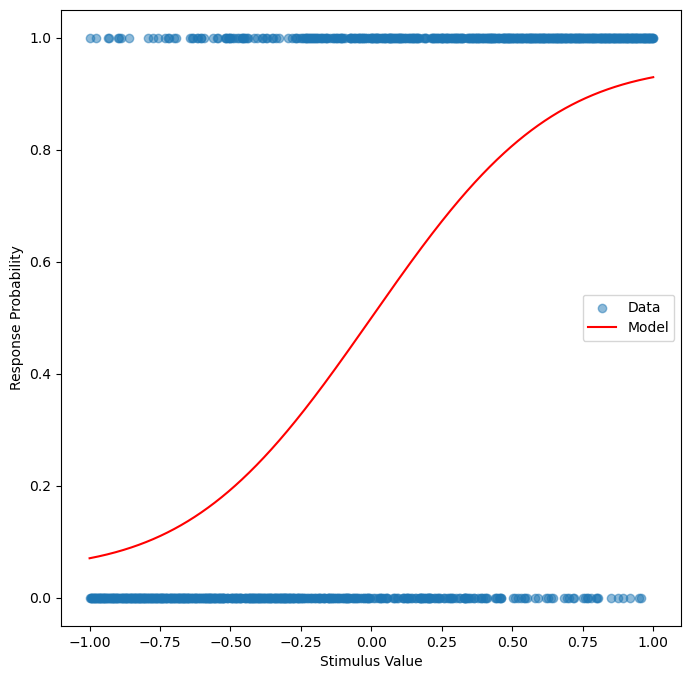

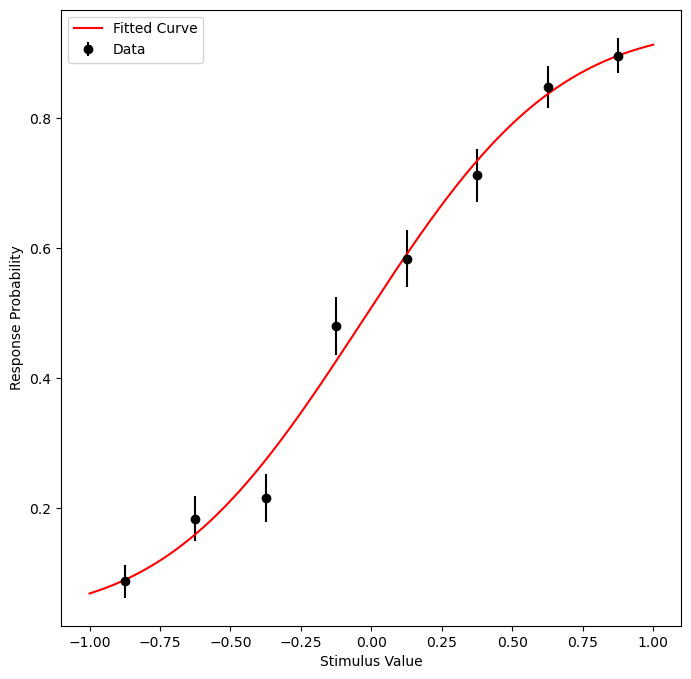

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 Choice   No. Observations:                  999
Model:                            GLM   Df Residuals:                      996
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -505.53
Date:                Mon, 12 Feb 2024   Deviance:                       1011.1
Time:                        19:23:06   Pearson chi2:                     994.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.3122
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -0.1020      0.117     

In [ ]:
## GLM - Trial History
### Generate Fake Data
def psychometric(s, mu, sigma, lapse1, lapse2):
    return lapse1 + (1 - lapse1 - lapse2) * norm.cdf(s, mu, sigma)

np.random.seed(42)  # for reproducibility
stimulus_values = np.linspace(-1, 1, 1000)  # stimuli values
mu, sigma, lapse1, lapse2 = 0, 0.5, 0.05, 0.05  # true parameters

# Compute the probability of choosing 1 for each value in s
probabilities = psychometric(stimulus_values, mu, sigma, lapse1, lapse2)

# Generate fake choices based on the probabilities
choices = np.array([np.random.choice([0, 1], p=[1 - p, p]) for p in probabilities])

# plot choice Vs s (stimulus values)
fig, ax = plt.subplots(figsize=(8,8))
plt.scatter(stimulus_values, choices, alpha=0.5, label='Data')
plt.plot(np.sort(stimulus_values), psychometric(np.sort(stimulus_values), mu, sigma, lapse1, lapse2), 'r-', label='Model')
plt.xlabel('Stimulus Value')
plt.ylabel('Response Probability')
plt.legend()
plt.show()
# store the stimulus values and choices in a dataframe
df = pd.DataFrame({'Stimulus': stimulus_values, 'Choice': choices})

# Define the bins
bins_negative = [-1.0, -0.75, -0.5, -0.25, 0.0]
bins_positive = [0.0, 0.25, 0.5, 0.75, 1.0]

# Create masks for negative and positive values
mask_negative = df['Stimulus'] < 0
mask_positive = df['Stimulus'] > 0

# Bin the negative values with left inclusivity
binned_negative = pd.cut(df[mask_negative]['Stimulus'], bins=bins_negative, right=False, labels = np.arange(-0.875, 0, 0.25))

# Bin the positive values with right inclusivity
binned_positive = pd.cut(df[mask_positive]['Stimulus'], bins=bins_positive, right=True, labels = np.arange(0.125, 1, 0.25))

# Convert the binned categories to strings
binned_negative = binned_negative.astype(str)
binned_positive = binned_positive.astype(str)

# Assign binned values using masks
df.loc[mask_negative, 'Stim_Binned'] = binned_negative
df.loc[mask_positive, 'Stim_Binned'] = binned_positive
# df['stim_relative_binned'] = df['stim_relative_binned'].astype('category')
df['Stim_Binned'] = pd.to_numeric(df['Stim_Binned'], errors='coerce')
### Parameter Recovery
# plot choice Vs stim_relative_binned, add error bars
df.groupby('Stim_Binned')['Choice'].agg(['mean', 'count', 'var', 'std', 'sem'])

# plot choice Vs stim_relative_binned, add error bars
df.groupby('Stim_Binned')['Choice'].agg(['mean', 'count', 'var', 'std', 'sem'])

fig, ax = plt.subplots(figsize=(8,8))
plt.errorbar(x=df.groupby('Stim_Binned')['Choice'].mean().index,
                y=df.groupby('Stim_Binned')['Choice'].mean(),
                yerr=df.groupby('Stim_Binned')['Choice'].sem(),
                fmt='o', color='k', ecolor='k', label='Data')
popt, pcov = curve_fit(psychometric, df.groupby('Stim_Binned')['Choice'].mean().index, 
                       df.groupby('Stim_Binned')['Choice'].mean(), 
                       p0=[0.0, 0.5, 0.1, 0.1], maxfev=10000)
y_fit = psychometric(np.sort(stimulus_values), *popt)
plt.plot(np.sort(stimulus_values), y_fit, 'r-', label='Fitted Curve')

plt.xlabel('Stimulus Value')
plt.ylabel('Response Probability')
plt.legend()
plt.show()

### Add serial effects
def add_serial_dependence(choices, p_stay):
    if not (0 <= p_stay <= 1):
        raise ValueError("p_stay must be between 0 and 1")

    modified_choices = np.copy(choices)  # Create a copy of choices to modify
    n = len(choices)

    for i in range(1, n):
        p_switch = 1 - p_stay  # Probability to switch from the previous choice
        current_choice = modified_choices[i - 1]
        
        # Decide the current choice based on p_stay
        if current_choice == 1:
            modified_choices[i] = np.random.choice([0, 1], p=[p_switch, p_stay])
        else:
            modified_choices[i] = np.random.choice([1, 0], p=[p_switch, p_stay])

    return modified_choices

# Add serial dependence
p_stay = 0.6  # example serial dependence strength
modified_choices =  add_serial_dependence(choices, p_stay)
# Create variables for previous stimulus and previous choice
df['Stimulus_Previous'] = df['Stimulus'].shift(1)
df['Choice_Previous'] = df['Choice'].shift(1)
# df['Choice_Modified'] = modified_choices
df


# Building the GLM
model = smf.glm(formula="Choice ~ Stimulus + Choice_Previous", data=df, family=sm.families.Binomial()).fit()

# Show the model summary
print(model.summary())



## Mouse simulator

### Unbiased data

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from joblib import Parallel, delayed
import random

def prep_GLM_data(df, 
                #   p_id, date, 
                #  condition,
                #  columns_to_keep, 
                 n_trials_back):
    """
    Prepares the data for GLM fitting by adding columns for previous trial data and filtering the dataframe.
    
    Args:
        df (pd.DataFrame): The input dataframe
        p_id (str): The participant ID
        date (str): The date
        columns_to_keep (list): The columns to keep in the output dataframe
        n_trials_back (int): The number of previous trials to include in the output dataframe

    Returns:
        X (pd.DataFrame): The input dataframe (regressors) with additional columns for previous trial data
        y (pd.Series): The choice column (dependent variable)
    """
    # sub_df = df[(df['Participant_ID'] == p_id) & (df['Date'] == date)].reset_index(drop=True)
    # Filter for the given condition
    # sub_df = df[df['Opto_Condition'] == condition]
    sub_df = df.groupby('Participant_ID', group_keys=False).apply(add_previous_n_trials_data, n=n_trials_back)
    # sub_df = sub_df[columns_to_keep]
    
    # add rewarded and unrewarded choice columns
    for i in range(1, n_trials_back + 1):
        sub_df[f'Rewarded_Choice_{i}'] = np.where((sub_df[f'correct_{i}'] == 1) & (sub_df[f'choice_{i}'] == 1), 1, 
                                              np.where((sub_df[f'correct_{i}'] == 1) & (sub_df[f'choice_{i}'] == 0), -1, 0))
        sub_df[f'Unrewarded_Choice_{i}'] = np.where((sub_df[f'correct_{i}'] == 0) & (sub_df[f'choice_{i}'] == 1), 1, 
                                                np.where((sub_df[f'correct_{i}'] == 0) & (sub_df[f'choice_{i}'] == 0), -1, 0))
        
    # sub_df = sub_df[sub_df.No_response == False].reset_index(drop=True)
    # drop any rows where choice_1, stim_relative_1, stim_relative_binned or choice is nan
    sub_df = sub_df.dropna(subset=["stimulus", "stimulus_1", "stimulus_2", "stimulus_3", "stimulus_4", "stimulus_5",
                                   "Rewarded_Choice_1", "Rewarded_Choice_2", "Rewarded_Choice_3", "Rewarded_Choice_4", "Rewarded_Choice_5",
                                   "Unrewarded_Choice_1", "Unrewarded_Choice_2", "Unrewarded_Choice_3", "Unrewarded_Choice_4", "Unrewarded_Choice_5",
                                   "choice"]).reset_index(drop=True)
    
    X = sub_df[[
            "stimulus",
            "stimulus_1", "stimulus_2", "stimulus_3", "stimulus_4", "stimulus_5",
            "Rewarded_Choice_1", "Rewarded_Choice_2", "Rewarded_Choice_3", "Rewarded_Choice_4", "Rewarded_Choice_5",
            "Unrewarded_Choice_1", "Unrewarded_Choice_2", "Unrewarded_Choice_3", "Unrewarded_Choice_4", "Unrewarded_Choice_5"
            ]] 
    
    y = sub_df['choice']
    
    return X, y

def train_and_evaluate_GLM(X_train, X_test, y_train, y_test):
    '''
    Trains and evaluates a logistic regression model.
    Args:
        X_train (np.array): The training data (regressors)
        X_test (np.array): The testing data (regressors)
        y_train (np.array): The training data (dependent variable)
        y_test (np.array): The testing data (dependent variable)
    Returns:
        coefficients (np.array): The coefficients from the logistic regression model
        intercept (float): The intercept from the logistic regression model
        accuracy (float): The accuracy of the logistic regression model
    '''

    model = LogisticRegression(penalty="l1", C=1, solver="saga", max_iter=5000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return model.coef_[0], model.intercept_[0], accuracy_score(y_test, y_pred)

def fit_GLM(X, y):
    """
    Fits a GLM to the data and returns the model.

    Args:
        X (pd.DataFrame): The input dataframe (regressors)
        y (pd.Series): The choice column (dependent variable)

    Returns:
        mean_cv_score (float): The mean cross-validation score
        log_reg_l1 (LogisticRegression): The fitted logistic regression model
    """
    log_reg_l1 = LogisticRegression(penalty="l1", C=1, solver="saga", max_iter=5000)
    log_reg_l1.fit(X, y)

    # Perform k-fold cross-validation (e.g., k=5)
    k_fold = 5
    cv_scores = cross_val_score(log_reg_l1, X, y, cv=k_fold, scoring='accuracy')
    mean_cv_score = np.mean(cv_scores)

    return mean_cv_score, log_reg_l1

def gen_coef_df(X, y, bootstrap_samples, n_folds):
    '''
    Generates a DataFrame with regression coefficients, confidence intervals, 
    and model accuracy after bootstrapping.
    Args:
        X (pd.DataFrame): The input data (regressors)
        y (pd.Series): The output data (dependent variable)
        bootstrap_samples (int): The number of bootstrap samples
        n_folds (int): The number of folds for KFold cross-validation
    Returns:
        coef_df (pd.DataFrame): A DataFrame containing the regressors, their 
        coefficients, confidence intervals, and model accuracy.
    '''
    X_np, y_np = X.values, y.values
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=1)

    results = Parallel(n_jobs=-1)(delayed(train_and_evaluate_GLM)(
        X_np[train_index], X_np[test_index], y_np[train_index], y_np[test_index])
        for i in range(bootstrap_samples) 
        for train_index, test_index in kf.split(X_np))

    coefficients = np.array([coef for coef, _, _ in results])
    intercepts = np.array([intercept for _, intercept, _ in results])
    accuracies = np.array([acc for _, _, acc in results])

    # Calculate the means and confidence intervals for coefficients
    coefficients_mean = np.mean(coefficients, axis=0)
    coefficients_conf_int_low = np.percentile(coefficients, 2.5, axis=0)
    coefficients_conf_int_high = np.percentile(coefficients, 97.5, axis=0)

    # Calculate the mean and confidence intervals for the intercept
    intercept_mean = np.mean(intercepts)
    intercept_conf_int_low = np.percentile(intercepts, 2.5)
    intercept_conf_int_high = np.percentile(intercepts, 97.5)

    # Combine the coefficients and the intercept into the DataFrame
    # Add a new row for the intercept in the DataFrame
    intercept_row = pd.DataFrame({
        'Regressor': ['Intercept'],
        'Coefficient': [intercept_mean],
        'Conf_Int_Low': [intercept_conf_int_low],
        'Conf_Int_High': [intercept_conf_int_high],
        'Accuracy': [np.mean(accuracies)]
    })

    coef_df = pd.DataFrame({
        'Regressor': X.columns,
        'Coefficient': coefficients_mean,
        'Conf_Int_Low': coefficients_conf_int_low,
        'Conf_Int_High': coefficients_conf_int_high
    })
    
    coef_df['Regressor'] = coef_df['Regressor'].replace('stimulus', 'stimulus_0')


    # Append the intercept row to the coefficients DataFrame
    coef_df = pd.concat([coef_df, intercept_row], ignore_index=True)

    # Add the average accuracy for all models as a new column
    coef_df['Accuracy'] = np.mean(accuracies)

    return coef_df

import numpy as np
import matplotlib.pyplot as plt

def plot_GLM_weights(coef_df, color_label_dict, ax, marker, linestyle):
    '''
    Plots the GLM weights for the stimulus, rewarded, and unrewarded regressors, 5 trials back, with specified colors and labels for each type, a unified marker style, and a specified linestyle.
    Args:
        coef_df (pd.DataFrame): The dataframe containing the coefficients for a specific condition.
        color_label_dict (dict): A dictionary specifying the colors and labels for stimulus, rewarded, and unrewarded data.
        ax (matplotlib.axes.Axes): The axes object to plot on.
        marker (str): The marker style for the plots.
        linestyle (str): The linestyle for the plots.
    '''
    background_alpha = 0.6
    trial_numbers = np.arange(0, -6, -1)
    marker_size = 7
    
    # Extracting data by type
    stim_data = coef_df[coef_df['Regressor'].str.contains('stimulus')]
    rewarded_data = coef_df[coef_df['Regressor'].str.contains('Rewarded_Choice')]
    unrewarded_data = coef_df[coef_df['Regressor'].str.contains('Unrewarded_Choice')]
    
    # Stimulus data
    if not stim_data.empty:
        ax.errorbar(trial_numbers[:6], stim_data['Coefficient'], 
                    yerr=[stim_data['Coefficient'] - stim_data['Conf_Int_Low'], stim_data['Conf_Int_High'] - stim_data['Coefficient']], 
                    fmt=marker, color=color_label_dict['Stimulus']['color'],
                    label=color_label_dict['Stimulus']['label'], alpha=background_alpha, markersize=marker_size, linestyle=linestyle)
        ax.plot(trial_numbers[:6], stim_data['Coefficient'], marker=marker, linestyle=linestyle, color=color_label_dict['Stimulus']['color'], markersize=marker_size)
    
    # Rewarded Choices
    if not rewarded_data.empty:
        ax.errorbar(trial_numbers[1:], rewarded_data['Coefficient'], 
                    yerr=[rewarded_data['Coefficient'] - rewarded_data['Conf_Int_Low'], rewarded_data['Conf_Int_High'] - rewarded_data['Coefficient']], 
                    fmt=marker, color=color_label_dict['Rewarded_Choice']['color'],
                    label=color_label_dict['Rewarded_Choice']['label'], alpha=background_alpha, markersize=marker_size, linestyle=linestyle)
        ax.plot(trial_numbers[1:], rewarded_data['Coefficient'], marker=marker, linestyle=linestyle, color=color_label_dict['Rewarded_Choice']['color'], markersize=marker_size)
    
    # Unrewarded Choices
    if not unrewarded_data.empty:
        ax.errorbar(trial_numbers[1:], unrewarded_data['Coefficient'], 
                    yerr=[unrewarded_data['Coefficient'] - unrewarded_data['Conf_Int_Low'], unrewarded_data['Conf_Int_High'] - unrewarded_data['Coefficient']], 
                    fmt=marker, color=color_label_dict['Unrewarded_Choice']['color'],
                    label=color_label_dict['Unrewarded_Choice']['label'], alpha=background_alpha, markersize=marker_size, linestyle=linestyle)
        ax.plot(trial_numbers[1:], unrewarded_data['Coefficient'], marker=marker, linestyle=linestyle, color=color_label_dict['Unrewarded_Choice']['color'], markersize=marker_size)

    # Bias
    bias_data = coef_df[coef_df['Regressor'] == 'Intercept']
    if not bias_data.empty:
        bias_coef = bias_data['Coefficient'].values[0]
        bias_ci_low = bias_data['Conf_Int_Low'].values[0]
        bias_ci_high = bias_data['Conf_Int_High'].values[0]

        ax.errorbar(-5.5, bias_coef, 
                    yerr=[[bias_coef - bias_ci_low], [bias_ci_high - bias_coef]], 
                    fmt=marker, color=color_label_dict['Bias']['color'],
                    label=color_label_dict['Bias']['label'], alpha=background_alpha, markersize=marker_size, linestyle=linestyle)

    ax.set_xlabel('Trials Back')
    ax.set_ylabel('Coefficient')
    ax.axhline(0, color='grey', linestyle='--')

    # Create custom handles for the legend if needed or use ax.legend() directly
    handles = [plt.Line2D([], [], marker=marker, color=info['color'], label=info['label'], linestyle=linestyle) for info in color_label_dict.values()]

    ax.legend(handles=handles)
    plt.tight_layout()

    return handles



def calculate_stay_probabilities(df):
    stay_given_correct = df[df['correct_1'] == 1]['Stayed'].mean()
    stay_given_incorrect = df[df['correct_1'] == 0]['Stayed'].mean()
    return [stay_given_correct, stay_given_incorrect]

def plot_stay_probabilities(p_stays, title, ylim=(0, 1), extra_lines=None):
    plt.figure(figsize=(8, 6))
    plt.bar(['Previous Correct', 'Previous Incorrect'], p_stays, color=['blue', 'orange'])
    plt.axhline(y=0.45, color='k', linestyle='--', alpha=0.5)
    plt.axhline(y=0.55, color='k', linestyle='--', alpha=0.5)
    if extra_lines:
        for y, color in extra_lines:
            plt.axhline(y=y, color=color, linestyle='--', alpha=0.5)
    plt.xlabel('Condition')
    plt.ylabel('Probability of Staying')
    plt.title(title)
    plt.ylim(*ylim)
    plt.show()

def change_proportion_of_zeroes_to_ones(choices, proportion):
    num_zeros = np.count_nonzero(choices == 0)
    num_changes = int(num_zeros * proportion)
    
    zero_indices = np.where(choices == 0)[0]
    indices_to_change = np.random.choice(zero_indices, num_changes, replace=False)
    
    choices[indices_to_change] = 1
    
    return choices

def compute_p_stay(sub_df):
    '''
    Compute the probability of staying given reward and no reward
    Args:
        sub_df (pd.DataFrame): The dataframe containing the relevant columns
    Returns:
        p_stay (float): The probability of staying
        p_stay_given_reward (float): The probability of staying given reward
        p_stay_given_no_reward (float): The probability of staying given no reward
    '''
    # calculate p_stay independent of reward
    p_stay = (sub_df['choice'] == sub_df['choice_1']).mean()
    
    # Given reward
    reward_df = sub_df[sub_df['correct_1'] == 1]
    p_stay_given_reward = (reward_df['choice'] == reward_df['choice_1']).mean()

    # No reward
    no_reward_df = sub_df[sub_df['correct_1'] == 0]
    p_stay_given_no_reward = (no_reward_df['choice'] == no_reward_df['choice_1']).mean()

    return p_stay, p_stay_given_reward, p_stay_given_no_reward

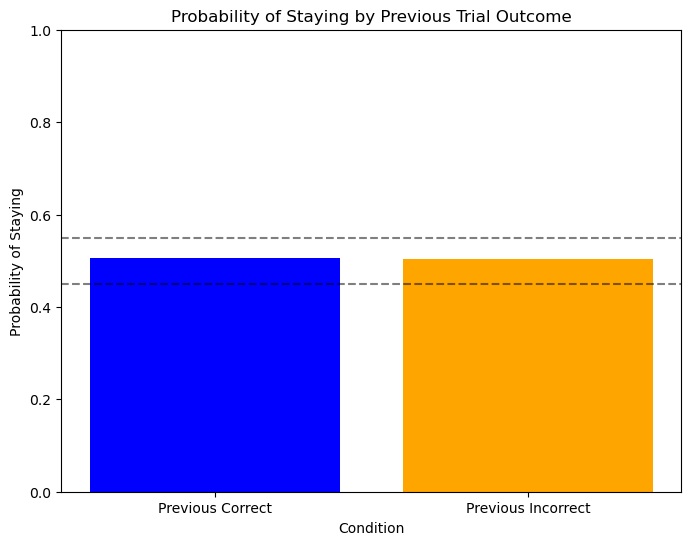

In [223]:
np.random.seed(42)

condition = 'baseline'
# set bias
bias_prop = 0 # Proportion of 0s to change to 1s
# set serial dependence
scaling_factor = 0

# Define simulation parameters
stimulus_values = np.linspace(-1, 1, 10000)
mu, sigma, lapse1, lapse2 = 0, 0.5, 0.05, 0.05

# Calculate probabilities using a psychometric function
probabilities = psychometric(stimulus_values, mu, sigma, lapse1, lapse2)

# Shuffle stimulus_values and probabilities together
shuffled_indices = np.random.permutation(len(probabilities))
stimulus_values = stimulus_values[shuffled_indices]
probabilities = probabilities[shuffled_indices]

# Vectorized choice generation
choices = np.random.binomial(1, probabilities)

choices = change_proportion_of_zeroes_to_ones(choices, bias_prop)

# Vectorized correctness calculation
correct = np.where(probabilities > 0.5, choices, 1 - choices).astype(int)

# Create dataframe with all necessary columns
df_base = pd.DataFrame({
    'probability': probabilities, 
    'stimulus': stimulus_values,
    'choice': choices, 
    'correct': correct,
    'Participant_ID': 'TEST'
})

# df_base['choice'] = df_base['choice'].replace(0, -1)

# Assume add_previous_n_trials_data is a function defined elsewhere
df_base = df_base.groupby('Participant_ID', group_keys=False).apply(add_previous_n_trials_data, n=5)
df_base['Stayed'] = (df_base['choice'] == df_base['choice_1']).astype(int)
df_base.loc[0, 'Stayed'] = np.nan  # Handle the first row explicitly

# Initial probabilities
p_stays = calculate_stay_probabilities(df_base)

# Plot for initial data
plot_stay_probabilities(p_stays, 'Probability of Staying by Previous Trial Outcome')

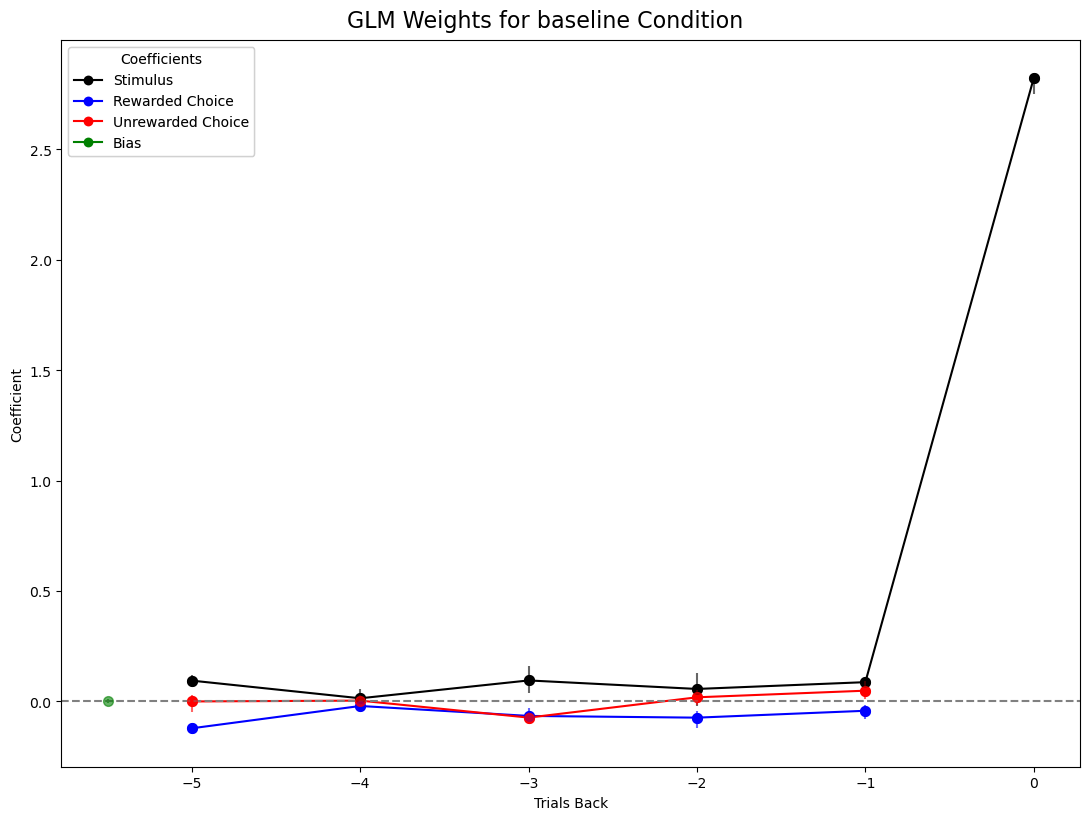

In [224]:
sub_df = df_base.copy()

X, y = prep_GLM_data(sub_df, n_trials_back=5)
coef_df = gen_coef_df(X, y, bootstrap_samples=10, n_folds=5)

color_label_dict = {
    'Stimulus': {'color': 'k', 'label': 'Stimulus'},  # Light Blue
    'Rewarded_Choice': {'color': 'blue', 'label': 'Rewarded Choice'},  # Light Green
    'Unrewarded_Choice': {'color': 'red', 'label': 'Unrewarded Choice'},  # Light Coral
    'Bias': {'color': 'green', 'label': 'Bias'}  # Light Goldenrod Yellow
}

marker_dict = {
              'No_Stim': 'o',
              'ACC': '^',
              'PPC': 's'
              }

fig, ax = plt.subplots(figsize=(11, 8))
color_handles = []  # List to collect color legend handles
# marker_handles = []  # List to collect marker legend handles

color_handles.extend(plot_GLM_weights(coef_df,
                                      color_label_dict=color_label_dict,
                                      ax=ax, marker=marker_dict['No_Stim']))


color_legend = ax.legend(handles=color_handles, loc='upper left', title="Coefficients")

ax.add_artist(color_legend) 

fig.suptitle(f'GLM Weights for {condition} Condition', fontsize=16, y=1.02)

plt.show()

In [225]:
# Stop execution at this cell
raise Exception('Stop here')

Exception: Stop here

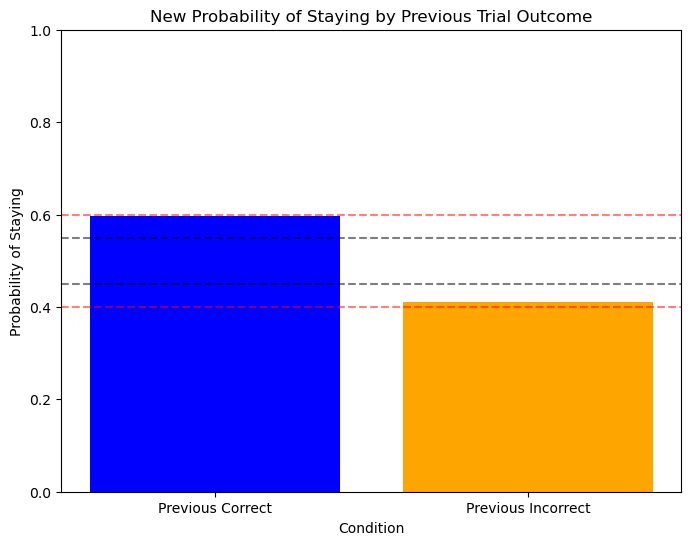

In [ ]:
scaling_factor = 0.686 # higher means stronger serial dependence

df_base['New_Probability'] = df_base.apply(calculate_new_probability, axis=1, args=(scaling_factor,))
new_probabilities = df_base['New_Probability']

new_choices = np.array([np.random.choice([0, 1], p=[1 - p, p]) for p in new_probabilities])
# add bias to the new choices
# proportion = 0.3  # Proportion of 0s to change to 1s
# new_choices = change_proportion_of_zeroes_to_ones(new_choices, proportion)

new_correct = (new_probabilities > 0.5) & (new_choices == 1) | (new_probabilities < 0.5) & (new_choices == 0)
df_serial = pd.DataFrame({'probability': new_probabilities,
                            'stimulus': df_base['stimulus'],
                            'choice': new_choices, 
                            'correct': new_correct,
                            'Participant_ID': 'TEST'})

# df_serial['choice'] = df_serial['choice'].replace(0, -1)

df_serial = df_serial.groupby('Participant_ID', group_keys=False).apply(add_previous_n_trials_data, n=1)
df_serial['Stayed'] = (df_serial['choice'] == df_serial['choice_1']).astype(int)
df_serial.loc[0, 'Stayed'] = np.nan  # Handle the first row explicitly

# Calculate probabilities
p_stays = calculate_stay_probabilities(df_serial)

# Plot for new data
plot_stay_probabilities(p_stays, 'New Probability of Staying by Previous Trial Outcome', extra_lines=[(0.4, 'r'), (0.6, 'r')])

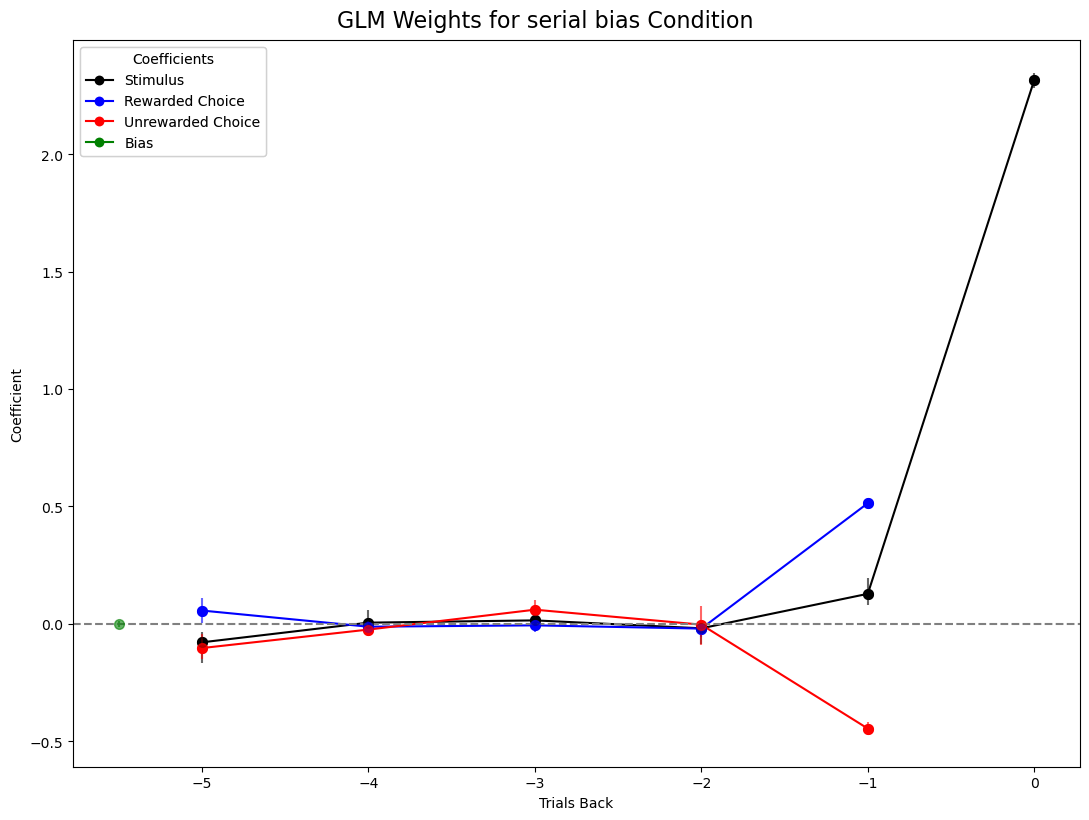

In [ ]:
condition = 'serial bias'

sub_df = df_serial.copy()

X, y = prep_GLM_data(sub_df, n_trials_back=5)
coef_df = gen_coef_df(X, y, bootstrap_samples=2, n_folds=5)
color_label_dict = {
    'Stimulus': {'color': 'k', 'label': 'Stimulus'},  # Light Blue
    'Rewarded_Choice': {'color': 'blue', 'label': 'Rewarded Choice'},  # Light Green
    'Unrewarded_Choice': {'color': 'red', 'label': 'Unrewarded Choice'},  # Light Coral
    'Bias': {'color': 'green', 'label': 'Bias'}  # Light Goldenrod Yellow
}

marker_dict = {
              'No_Stim': 'o',
              'ACC': '^',
              'PPC': 's'
              }

fig, ax = plt.subplots(figsize=(11, 8))
color_handles = []  # List to collect color legend handles
# marker_handles = []  # List to collect marker legend handles

color_handles.extend(plot_GLM_weights(coef_df,
                                      color_label_dict=color_label_dict,
                                      ax=ax, marker=marker_dict['No_Stim']))


color_legend = ax.legend(handles=color_handles, loc='upper left', title="Coefficients")

ax.add_artist(color_legend) 

fig.suptitle(f'GLM Weights for {condition} Condition', fontsize=16, y=1.02)

plt.show()

In [ ]:
# Interrupt execution at this cell
raise Exception('Stop here')

In [536]:
np.random.seed(42)  # for reproducibility
# initiliaze all weights
stim_weights = weights = np.append(2.8, np.random.uniform(-0.1, 0.1, 5))
rewarded_weights = np.random.uniform(-1.5, 1.5, 5)
unrewarded_weights = np.random.uniform(-0.1, 0.1, 5)
bias = np.random.uniform(-0.1, 0.1, 1)
regressors = np.append(X.columns.values, 'Intercept')

# store the weights in a dataframe
weights_df = pd.DataFrame({
    'Regressor': regressors,
    'Coefficient': np.concatenate((stim_weights, rewarded_weights, unrewarded_weights, bias)),
    'Conf_Int_Low': np.nan,
    'Conf_Int_High': np.nan,
    'Accuracy': np.nan
    })
# replace stimmulus with stimulus_0
weights_df['Regressor'] = weights_df['Regressor'].replace('stimulus', 'stimulus_0')

In [537]:
n_trials = 100000
stimulus_values = np.linspace(-1, 1, n_trials)
stimulus_values = np.random.choice(stimulus_values, size=n_trials, replace=False)

# initialise first 6 trials
stimuli = stimulus_values[:6]
probabilities = psychometric(stimuli, mu, sigma, lapse1, lapse2)
choices = np.random.binomial(1, probabilities)
correct = np.where(probabilities > 0.5, choices, 1 - choices).astype(int)

df_initial = pd.DataFrame({'stimulus': stimuli, 'choice': choices, 'correct': correct, 'Participant_ID': 'TEST'})
# set choice and correct at row 5 to nan
df_initial.loc[5, 'choice'] = np.nan
df_initial.loc[5, 'correct'] = np.nan
# add previous trials data
df_initial = df_initial.groupby('Participant_ID', group_keys=False).apply(add_previous_n_trials_data, n=5)
# add a Rewarded_
df_initial = df_initial.append(pd.DataFrame({'stimulus': stimulus_values[6:n_trials]}), ignore_index=True)
# keep the Participant_ID column the same
df_initial['Participant_ID'] = 'TEST'

sub_df = df_initial.copy()

n_trials_back = 5
for i in range(1, n_trials_back + 1):
    sub_df[f'Rewarded_Choice_{i}'] = np.where((sub_df[f'correct_{i}'] == 1) & (sub_df[f'choice_{i}'] == 1), 1, 
                                            np.where((sub_df[f'correct_{i}'] == 1) & (sub_df[f'choice_{i}'] == 0), -1, 0))
    sub_df[f'Unrewarded_Choice_{i}'] = np.where((sub_df[f'correct_{i}'] == 0) & (sub_df[f'choice_{i}'] == 1), 1, 
                                            np.where((sub_df[f'correct_{i}'] == 0) & (sub_df[f'choice_{i}'] == 0), -1, 0))
# replace the stimulus column with stimulus_0
sub_df = sub_df.rename(columns={'stimulus': 'stimulus_0'})

/var/folders/36/99q57ldx4j956537wjswtd4c0000gn/T/ipykernel_18243/4178989733.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_initial = df_initial.append(pd.DataFrame({'stimulus': stimulus_values[6:n_trials]}), ignore_index=True)


In [538]:
# # Fill 'choice' and 'correct' columns with a combination of other columns
# for index in range(5, n_trials):
#     # print(index)
#     # print every 1000th index
#     if index % 100 == 0:
#         print(index)
#     z = (weights_df[weights_df.Regressor == 'stimulus_0']['Coefficient'].values[0] * sub_df.iloc[index].stimulus_0 + 
#     weights_df[weights_df.Regressor == 'Rewarded_Choice_1']['Coefficient'].values[0] * sub_df.iloc[index].Rewarded_Choice_1 +
#     weights_df[weights_df.Regressor == 'Rewarded_Choice_2']['Coefficient'].values[0] * sub_df.iloc[index].Rewarded_Choice_2 +
#     weights_df[weights_df.Regressor == 'Rewarded_Choice_3']['Coefficient'].values[0] * sub_df.iloc[index].Rewarded_Choice_3 +
#     weights_df[weights_df.Regressor == 'Rewarded_Choice_4']['Coefficient'].values[0] * sub_df.iloc[index].Rewarded_Choice_4 +
#     weights_df[weights_df.Regressor == 'Rewarded_Choice_5']['Coefficient'].values[0] * sub_df.iloc[index].Rewarded_Choice_5 +
#     weights_df[weights_df.Regressor == 'Unrewarded_Choice_1']['Coefficient'].values[0] * sub_df.iloc[index].Unrewarded_Choice_1 +
#     weights_df[weights_df.Regressor == 'Unrewarded_Choice_2']['Coefficient'].values[0] * sub_df.iloc[index].Unrewarded_Choice_2 +
#     weights_df[weights_df.Regressor == 'Unrewarded_Choice_3']['Coefficient'].values[0] * sub_df.iloc[index].Unrewarded_Choice_3 +
#     weights_df[weights_df.Regressor == 'Unrewarded_Choice_4']['Coefficient'].values[0] * sub_df.iloc[index].Unrewarded_Choice_4 +
#     weights_df[weights_df.Regressor == 'Unrewarded_Choice_5']['Coefficient'].values[0] * sub_df.iloc[index].Unrewarded_Choice_5 +
#     weights_df[weights_df.Regressor == 'Intercept']['Coefficient'].values[0]
#         )
#     # print(probability)

#     probability = 1 / (1 + np.exp(-z))
#     choice = np.random.binomial(1, probability)
#     # choice is correct if stimulus_0 if > 0.5 and choice is 1 or stimulus_0 is < 0.5 and choice is 0, else incorrect
#     stimulus  =  sub_df.iloc[index].stimulus_0
#     correct = (stimulus > 0.5) & (choice == 1) | (stimulus < 0.5) & (choice == 0)
#     # need correct to be 1 or 0
#     correct = correct.astype(int)
#     sub_df.loc[index, 'choice'] = choice
#     sub_df.loc[index, 'correct'] = correct

#      # fill in the rewarded and unrewarded choices for the next trial
#     if correct == 1 and choice == 1:
#         sub_df.loc[index + 1, 'Rewarded_Choice_1'] = 1
#         sub_df.loc[index + 1, 'Unrewarded_Choice_1'] = 0
#     elif correct == 1 and choice == 0:
#         sub_df.loc[index + 1, 'Rewarded_Choice_1'] = -1
#         sub_df.loc[index + 1, 'Unrewarded_Choice_1'] = 0
#     elif correct == 0 and choice == 1:
#         sub_df.loc[index + 1, 'Rewarded_Choice_1'] = 0
#         sub_df.loc[index + 1, 'Unrewarded_Choice_1'] = 1
#     else:
#         sub_df.loc[index + 1, 'Rewarded_Choice_1'] = 0
#         sub_df.loc[index + 1, 'Unrewarded_Choice_1'] = -1


    
#     # for sub_df.loc[index, 'Rewarded_Choice_2'], it is similar to sub_df.loc[index, 'Rewarded_Choice_1'] but but of the previous trial
#     sub_df.loc[index + 1, 'Rewarded_Choice_2'] = sub_df.loc[index, 'Rewarded_Choice_1']
#     sub_df.loc[index + 1, 'Unrewarded_Choice_2'] = sub_df.loc[index, 'Unrewarded_Choice_1']
#     sub_df.loc[index + 1, 'Rewarded_Choice_3'] = sub_df.loc[index, 'Rewarded_Choice_2']
#     sub_df.loc[index + 1, 'Unrewarded_Choice_3'] = sub_df.loc[index, 'Unrewarded_Choice_2']
#     sub_df.loc[index + 1, 'Rewarded_Choice_4'] = sub_df.loc[index, 'Rewarded_Choice_3']
#     sub_df.loc[index + 1, 'Unrewarded_Choice_4'] = sub_df.loc[index, 'Unrewarded_Choice_3']
#     sub_df.loc[index + 1, 'Rewarded_Choice_5'] = sub_df.loc[index, 'Rewarded_Choice_4']
#     sub_df.loc[index + 1, 'Unrewarded_Choice_5'] = sub_df.loc[index, 'Unrewarded_Choice_4']

In [539]:
# Convert weights to a dictionary for quick access
weights = weights_df.set_index('Regressor')['Coefficient'].to_dict()

# Pre-allocate 'choice' and 'correct' columns if not already present
if 'choice' not in sub_df.columns:
    sub_df['choice'] = np.nan
if 'correct' not in sub_df.columns:
    sub_df['correct'] = np.nan

# Loop optimization: Direct access instead of querying DataFrame
for index in range(5, n_trials):
    # print every 1000th index
    if index % 1000 == 0:
        print(index)
    z = weights['Intercept']
    for reg in ['stimulus_0', 
                'Rewarded_Choice_1', 'Rewarded_Choice_2', 'Rewarded_Choice_3', 'Rewarded_Choice_4', 'Rewarded_Choice_5', 
                'Unrewarded_Choice_1', 'Unrewarded_Choice_2', 'Unrewarded_Choice_3', 'Unrewarded_Choice_4', 'Unrewarded_Choice_5']:
        z += sub_df.at[index, reg] * weights.get(reg, 0)

    probability = 1 / (1 + np.exp(-z))
    choice = np.random.binomial(1, probability)
    stimulus = sub_df.at[index, 'stimulus_0']
    correct = int((stimulus > 0.5 and choice == 1) or (stimulus <= 0.5 and choice == 0))

    sub_df.at[index, 'choice'] = choice
    sub_df.at[index, 'correct'] = correct

    # Ensure the DataFrame has a row for index + 1
    if index + 1 < n_trials:
        # Update next trial's values based on current choice and correctness
        sub_df.at[index + 1, 'Rewarded_Choice_1'] = 1 if correct == 1 and choice == 1 else -1 if correct == 1 and choice == 0 else 0
        sub_df.at[index + 1, 'Unrewarded_Choice_1'] = 1 if correct == 0 and choice == 1 else -1 if correct == 0 and choice == 0 else 0

        # Shift previous choices forward
        for i in range(1, 5):
            sub_df.at[index + 1, f'Rewarded_Choice_{i+1}'] = sub_df.at[index, f'Rewarded_Choice_{i}']
            sub_df.at[index + 1, f'Unrewarded_Choice_{i+1}'] = sub_df.at[index, f'Unrewarded_Choice_{i}']



1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000


In [540]:
# I am trying to generate choices using a logistic regression model, then recover the parameters using the model
# I have a set of initilaized weights stored in weights_df
# I have the first 5 trials of the data stored in sub_df and I want to generate all the subesequent trials using the weights (which go 5 trials back) and the stimulus_0 column
# naturewally, the chouce and correct columns of sub_df need to be updated as we progress through the indices
# equally, the Rewarded_Choice and Unrewarded_Choice columns need to be updated as we progress through the indices too
# help me implement this

In [541]:
# replace stimulus_0 with stimulus
sub_df = sub_df.rename(columns={'stimulus_0': 'stimulus'})

/Users/quentin/anaconda3/envs/sound_cat/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1185: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
/Users/quentin/anaconda3/envs/sound_cat/lib/python3.10/site-packages/matplotlib/axes/_axes.py:1186: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])


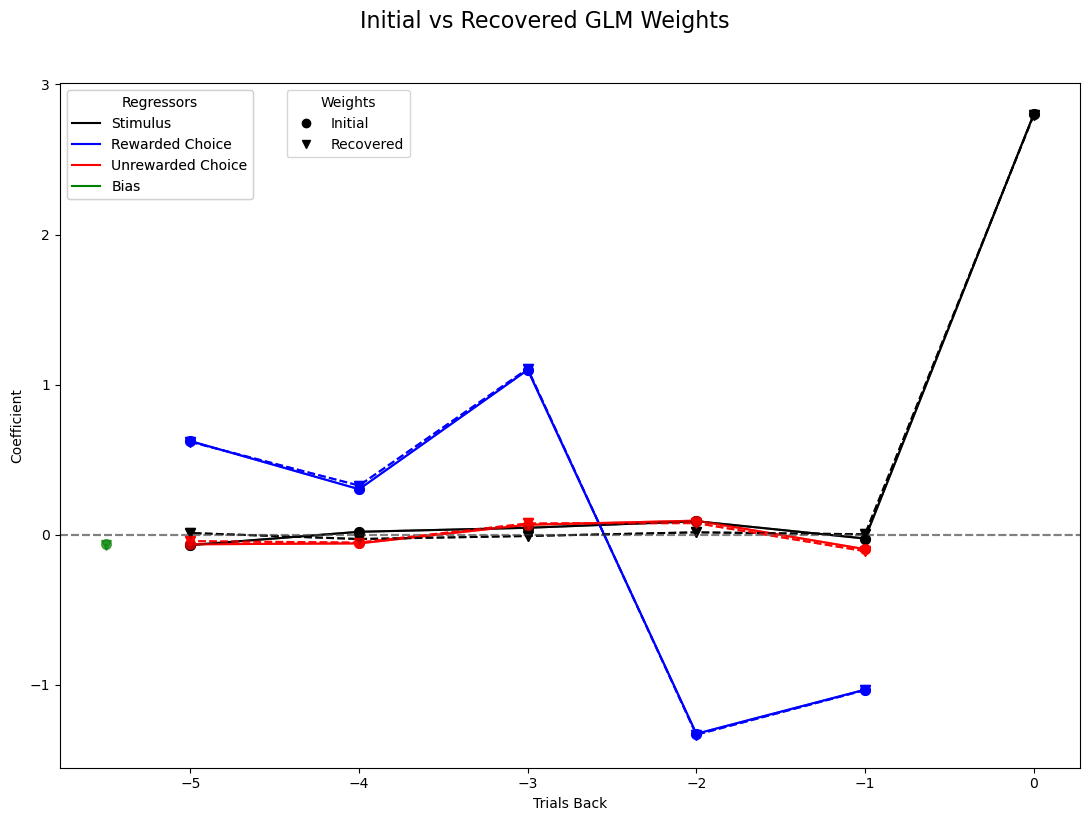

In [542]:
weights_marker_dict = {
                'Initial': 'o',
                'Recovered': 'v',
                }

X, y = prep_GLM_data(sub_df, n_trials_back=5)
coef_df = gen_coef_df(X, y, bootstrap_samples=1000, n_folds=5)

fig, ax = plt.subplots(figsize=(11, 8))
marker_handles = []  # List to collect marker legend handles
color_handles = []  # List to collect color legend handles

# Plot the initial weights
color_handles.extend(plot_GLM_weights(weights_df, color_label_dict, ax, weights_marker_dict['Initial'], linestyle='-'))

# Plot the recovered weights
color_handles.extend(plot_GLM_weights(coef_df, color_label_dict, ax, weights_marker_dict['Recovered'], linestyle='--'))

color_handles = [plt.Line2D([], [], color=color_info['color'], linestyle='-', label=color_info['label'])
                 for color_info in color_label_dict.values()]

for condition, marker in weights_marker_dict.items():
    marker_handles.append(plt.Line2D([], [], color='black', marker=marker, linestyle='None', label=condition))

color_legend = ax.legend(handles=color_handles, loc='upper left', title="Regressors")

ax.add_artist(color_legend)  # Manually add the color legend back
marker_legend = ax.legend(handles=marker_handles,
                           bbox_to_anchor=(0.35, 1),
                             title="Weights")

ax.add_artist(color_legend)

# add title
fig.suptitle('Initial vs Recovered GLM Weights', fontsize=16, y=1.02)
# save in FIGS_PATH
FIGS_PATH = '/Users/quentin/Desktop/HeadFixedBehavior/Analysis/Figures/'

plt.tight_layout()
plt.savefig(os.path.join(FIGS_PATH, 'initial_vs_recovered_weights.pdf'), dpi = 300, bbox_inches = 'tight')

plt.show()

In [543]:
# Break here
raise Exception('Stop here')

Exception: Stop here